<a href="https://colab.research.google.com/github/sid-betalol/Document-Classification-Models/blob/main/DiT_finetuning_tobacco3482.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install transformers[torch] -U
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 52.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 270.9/270.9 kB 31.3 MB/s eta 0:00:00
  Attempting uninstall: transformers
    Found existing installation: transformers 4.35.2
    Uninstalling transformers-4.35.2:
      Successfully uninstalled transformers-4.35.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.5 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 16.8 MB/s eta 0:00:00


In [2]:
import numpy as np
import torch
from datasets import load_dataset
from transformers import AutoModelForImageClassification, AutoFeatureExtractor, TrainingArguments, Trainer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_fscore_support
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import io
import seaborn as sns
import matplotlib.pyplot as plt
from torch.utils.data import IterableDataset
import os

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
task = 'tobacco3482'

In [5]:
torch.manual_seed(42)
np.random.seed(42)

In [6]:
num_labels = 10

In [7]:
dataset = load_dataset('maveriq/tobacco3482')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/3482 [00:00<?, ? examples/s]

In [8]:
feature_extractor = AutoFeatureExtractor.from_pretrained("microsoft/dit-base")

preprocessor_config.json:   0%|          | 0.00/302 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/beit/feature_extraction_beit.py:28: FutureWarning: The class BeitFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use BeitImageProcessor instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/models/beit/image_processing_beit.py:110: FutureWarning: The `reduce_labels` parameter is deprecated and will be removed in a future version. Please use `do_reduce_labels` instead.
  warnings.warn(


In [9]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, ds, feature_extractor, indices):
        self.ds = ds.select(indices)  # Select the specified indices
        self.feature_extractor = feature_extractor

    def __len__(self):
        return len(self.ds)

    def __getitem__(self, idx):
        item = self.ds[idx]
        if isinstance(item['image'], bytes):
            # If it's bytes, convert it to an image
            image = Image.open(io.BytesIO(item['image']))
        else:
            # If it's already an image, use it directly
            image = item['image']
        if image.mode != 'RGB':
            image = image.convert('RGB')
        pixel_values = self.feature_extractor(images=image, return_tensors="pt").pixel_values.squeeze()
        label = torch.tensor(item['label'])
        return {"pixel_values": pixel_values, "labels": label}

In [10]:
train_indices, test_indices = train_test_split(list(range(len(dataset['train']))), test_size=0.2, random_state=42)

In [11]:
train_dataset = CustomDataset(dataset['train'], feature_extractor, train_indices)
test_dataset = CustomDataset(dataset['train'], feature_extractor, test_indices)

In [12]:
model = AutoModelForImageClassification.from_pretrained("microsoft/dit-base", num_labels=num_labels)

config.json:   0%|          | 0.00/1.03k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/369M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Some weights of BeitForImageClassification were not initialized from the model checkpoint at microsoft/dit-base and are newly initialized: ['beit.pooler.layernorm.bias', 'beit.pooler.layernorm.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [13]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='weighted')
    acc = accuracy_score(labels, predictions)
    # Optionally print a classification report here or save it to a file
    report = classification_report(labels, predictions, target_names=[f'Class {i}' for i in range(num_labels)], digits=4)
    print(report)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

In [14]:
training_args = TrainingArguments(
    output_dir=f"/content/drive/MyDrive/rvl-cdip-pp/DiT/{task}/results",
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir=f"/content/drive/MyDrive/rvl-cdip-pp/DiT/{task}/logs",
    logging_steps=10,
    evaluation_strategy="epoch"
    # Since we're aiming for 3 epochs, max_steps might not be necessary here
    # but if you choose to use it, set max_steps=600
    # max_steps=1000  # Optional based on the above explanation
)

In [15]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)

In [16]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.476600,0.412966,0.879484,0.871696,0.879945,0.879484
2,0.295500,0.434363,0.898135,0.896654,0.901967,0.898135
3,0.297000,0.381761,0.934003,0.932343,0.934154,0.934003


              precision    recall  f1-score   support

     Class 0     0.9464    0.9298    0.9381        57
     Class 1     0.9925    0.9852    0.9888       135
     Class 2     0.8252    0.9659    0.8901        88
     Class 3     0.8571    0.9836    0.9160       122
     Class 4     0.9057    0.8807    0.8930       109
     Class 5     0.9375    0.8824    0.9091        34
     Class 6     0.9600    0.6667    0.7869        36
     Class 7     0.6885    0.8750    0.7706        48
     Class 8     0.8462    0.7333    0.7857        15
     Class 9     0.7037    0.3585    0.4750        53

    accuracy                         0.8795       697
   macro avg     0.8663    0.8261    0.8353       697
weighted avg     0.8799    0.8795    0.8717       697

              precision    recall  f1-score   support

     Class 0     0.9655    0.9825    0.9739        57
     Class 1     1.0000    0.9852    0.9925       135
     Class 2     0.8916    0.8409    0.8655        88
     Class 3     0.9402 

TrainOutput(global_step=1047, training_loss=0.6896394507420439, metrics={'train_runtime': 1364.4875, 'train_samples_per_second': 6.123, 'train_steps_per_second': 0.767, 'total_flos': 6.475673349798912e+17, 'train_loss': 0.6896394507420439, 'epoch': 3.0})

In [17]:
trainer.evaluate()

              precision    recall  f1-score   support

     Class 0     0.9655    0.9825    0.9739        57
     Class 1     1.0000    0.9926    0.9963       135
     Class 2     0.8854    0.9659    0.9239        88
     Class 3     0.9084    0.9754    0.9407       122
     Class 4     0.9298    0.9725    0.9507       109
     Class 5     1.0000    0.9706    0.9851        34
     Class 6     1.0000    0.8056    0.8923        36
     Class 7     0.8750    0.7292    0.7955        48
     Class 8     1.0000    1.0000    1.0000        15
     Class 9     0.8298    0.7358    0.7800        53

    accuracy                         0.9340       697
   macro avg     0.9394    0.9130    0.9238       697
weighted avg     0.9342    0.9340    0.9323       697



{'eval_loss': 0.3817610740661621,
 'eval_accuracy': 0.9340028694404591,
 'eval_f1': 0.9323430154824087,
 'eval_precision': 0.9341537697323402,
 'eval_recall': 0.9340028694404591,
 'eval_runtime': 76.1894,
 'eval_samples_per_second': 9.148,
 'eval_steps_per_second': 1.155,
 'epoch': 3.0}

In [18]:
predictions = trainer.predict(test_dataset)
labels = predictions.label_ids
preds = np.argmax(predictions.predictions, axis=-1)

              precision    recall  f1-score   support

     Class 0     0.9655    0.9825    0.9739        57
     Class 1     1.0000    0.9926    0.9963       135
     Class 2     0.8854    0.9659    0.9239        88
     Class 3     0.9084    0.9754    0.9407       122
     Class 4     0.9298    0.9725    0.9507       109
     Class 5     1.0000    0.9706    0.9851        34
     Class 6     1.0000    0.8056    0.8923        36
     Class 7     0.8750    0.7292    0.7955        48
     Class 8     1.0000    1.0000    1.0000        15
     Class 9     0.8298    0.7358    0.7800        53

    accuracy                         0.9340       697
   macro avg     0.9394    0.9130    0.9238       697
weighted avg     0.9342    0.9340    0.9323       697



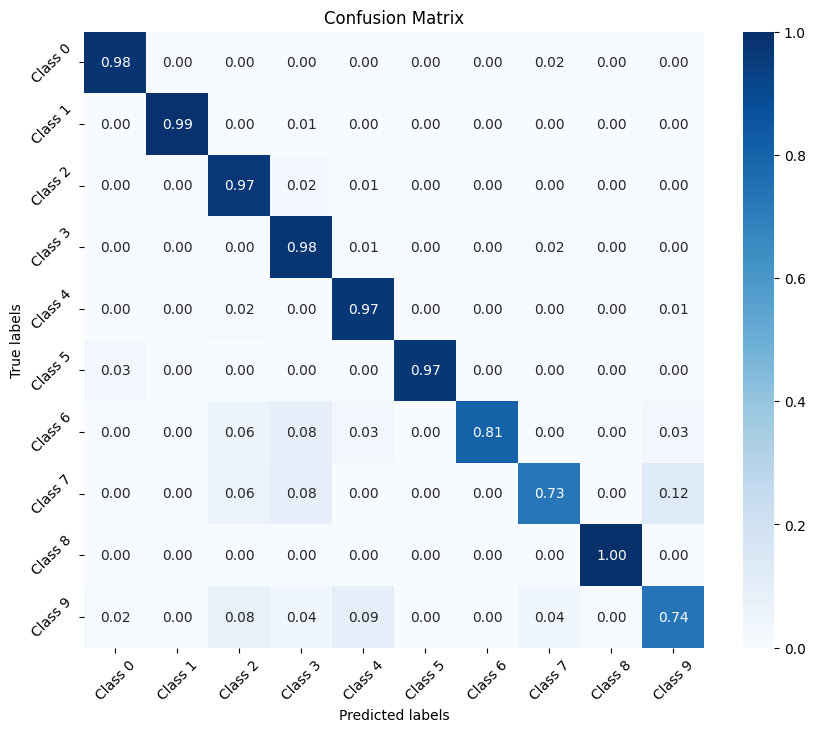

In [19]:
cm = confusion_matrix(labels, preds, normalize='true')
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='.2f',
            xticklabels=[f'Class {i}' for i in range(num_labels)],
            yticklabels=[f'Class {i}' for i in range(num_labels)])
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()